In [348]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings, random
warnings.filterwarnings(action='ignore')

import scipy.stats as stats 


from IPython.display import set_matplotlib_formats

mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus =True)
set_matplotlib_formats('retina')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import SMOTENC

In [349]:
train=pd.read_csv('train3.csv')
test=pd.read_csv('test3.csv')

In [350]:
for df in [train,test]:
    df.drop('Unnamed: 0',axis=1,inplace=True)

In [334]:
for i in [train,test]:
    i[i.duplicated()]

In [335]:
for i in [train,test]:
    i['dup']=''
    i['dup']=np.where(i.duplicated()==True,'egtikeul','unique')

In [336]:
collist = list(train.columns)

In [319]:
def dup(df,col):
    collist = list(df.columns)
    
    for i in col:
        collist.remove(i)
    
    return(df.duplicated(subset = collist, keep = False).sum())

In [287]:
for i in collist:
    print('begin_month', '& %-13s' % i, f' 외 중복 데이터 : {dup(train,[i,"begin_month"])}건')

begin_month & gender         외 중복 데이터 : 20389건
begin_month & car            외 중복 데이터 : 20370건
begin_month & reality        외 중복 데이터 : 20376건
begin_month & child_num      외 중복 데이터 : 20370건
begin_month & income_total   외 중복 데이터 : 20379건
begin_month & income_type    외 중복 데이터 : 20379건
begin_month & edu_type       외 중복 데이터 : 20370건
begin_month & family_type    외 중복 데이터 : 20384건
begin_month & house_type     외 중복 데이터 : 20370건
begin_month & DAYS_BIRTH     외 중복 데이터 : 20800건
begin_month & DAYS_EMPLOYED  외 중복 데이터 : 20370건
begin_month & work_phone     외 중복 데이터 : 20370건
begin_month & phone          외 중복 데이터 : 20370건
begin_month & email          외 중복 데이터 : 20375건
begin_month & occyp_type     외 중복 데이터 : 20370건
begin_month & family_size    외 중복 데이터 : 20374건


ValueError: list.remove(x): x not in list

In [351]:
# for df in [train,test]:
#     # before_EMPLOYED: 고용되기 전까지의 일수
#     df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
#     df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
#     df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
#     df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)
    
#     #DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
#     df['Age'] = df['DAYS_BIRTH'] // 365
#     df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
#     df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)

    
#     #DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
#     df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
#     df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
#     df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

#     #ability: 소득/(살아온 일수+ 근무일수)
#     df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])
    
#     #income_mean: 소득/ 가족 수
#     df['income_mean'] = df['income_total'] / df['family_size']
for df in [train,test]:
    df['ID'] = \
    df['income_total'].astype(str) + '_' +\
    df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
    df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' +\
    df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
    df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
    df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
    df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
    df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)+'_'+df['child_num'].astype(str)  

In [352]:
df['income_total']=np.log1p(df['income_total'])
# df['income_mean']=np.log1p(df['income_mean'])

In [339]:
train['dup'].value_counts()

unique      24816
egtikeul     1634
Name: dup, dtype: int64

In [340]:
test['dup'].value_counts()

unique      9648
egtikeul     352
Name: dup, dtype: int64

In [341]:
for df in [train,test]:
    df.drop('dup',axis=1,inplace=True)

In [353]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  9
Number of Categorical features:  9


In [343]:
# encoder = OrdinalEncoder(categorical_feats)
# train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
# test[categorical_feats] = encoder.transform(test[categorical_feats])

# train['ID'] = train['ID'].astype('int64')
# test['ID'] = test['ID'].astype('int64')

In [344]:
train.dtypes

gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit           float64
ID                object
dtype: object

In [355]:
# numerical_feats.remove('income_total')
# numerical_feats.remove('income_mean')
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

In [356]:
n_est = 2000
seed = 42
n_fold = 15
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [357]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['gender','car','ID','reality','income_type','edu_type','family_type','house_type','occyp_type']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier(n_estimators=n_est)
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=200, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.088345
0:	learn: 1.0488877	test: 1.0477502	best: 1.0477502 (0)	total: 33.4ms	remaining: 1m 6s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

100:	learn: 0.7112538	test: 0.6422772	best: 0.6422772 (100)	total: 5.48s	remaining: 1m 43s
200:	learn: 0.6971044	test: 0.6406316	best: 0.6404667 (192)	total: 12s	remaining: 1m 47s
300:	learn: 0.6851168	test: 0.6406358	best: 0.6400959 (260)	total: 18.3s	remaining: 1m 43s
400:	learn: 0.6731636	test: 0.6405696	best: 0.6399598 (317)	total: 24.7s	remaining: 1m 38s
500:	learn: 0.6608096	test: 0.6409409	best: 0.6399598 (317)	total: 31.3s	remaining: 1m 33s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6399598365
bestIteration = 317

Shrink model to first 318 iterations.
CV Log Loss Score: 0.639960

----------------- Fold 1 -----------------

Learning rate set to 0.088345
0:	learn: 1.0488226	test: 1.0482124	best: 1.0482124 (0)	total: 36.8ms	remaining: 1m 13s
100:	learn: 0.7112820	test: 0.6743604	best: 0.6743604 (100)	total: 5.59s	remaining: 1m 45s
200:	learn: 0.6968685	test: 0.6720894	best: 0.6716129 (176)	total: 12.2s	remaining: 1m 49s
300:	learn: 0.6855514	test: 0.67193

700:	learn: 0.6375188	test: 0.6597225	best: 0.6594426 (673)	total: 46.4s	remaining: 1m 25s
800:	learn: 0.6264690	test: 0.6605484	best: 0.6594426 (673)	total: 53.3s	remaining: 1m 19s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6594425712
bestIteration = 673

Shrink model to first 674 iterations.
CV Log Loss Score: 0.659443

----------------- Fold 11 -----------------

Learning rate set to 0.088345
0:	learn: 1.0486862	test: 1.0490321	best: 1.0490321 (0)	total: 23.9ms	remaining: 47.8s
100:	learn: 0.7079834	test: 0.6893516	best: 0.6893176 (99)	total: 5.82s	remaining: 1m 49s
200:	learn: 0.6953055	test: 0.6869513	best: 0.6869432 (199)	total: 12.2s	remaining: 1m 49s
300:	learn: 0.6834590	test: 0.6872277	best: 0.6863553 (268)	total: 18.7s	remaining: 1m 45s
400:	learn: 0.6706811	test: 0.6871403	best: 0.6863553 (268)	total: 25.3s	remaining: 1m 41s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6863553276
bestIteration = 268

Shrink model to first 26

In [358]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

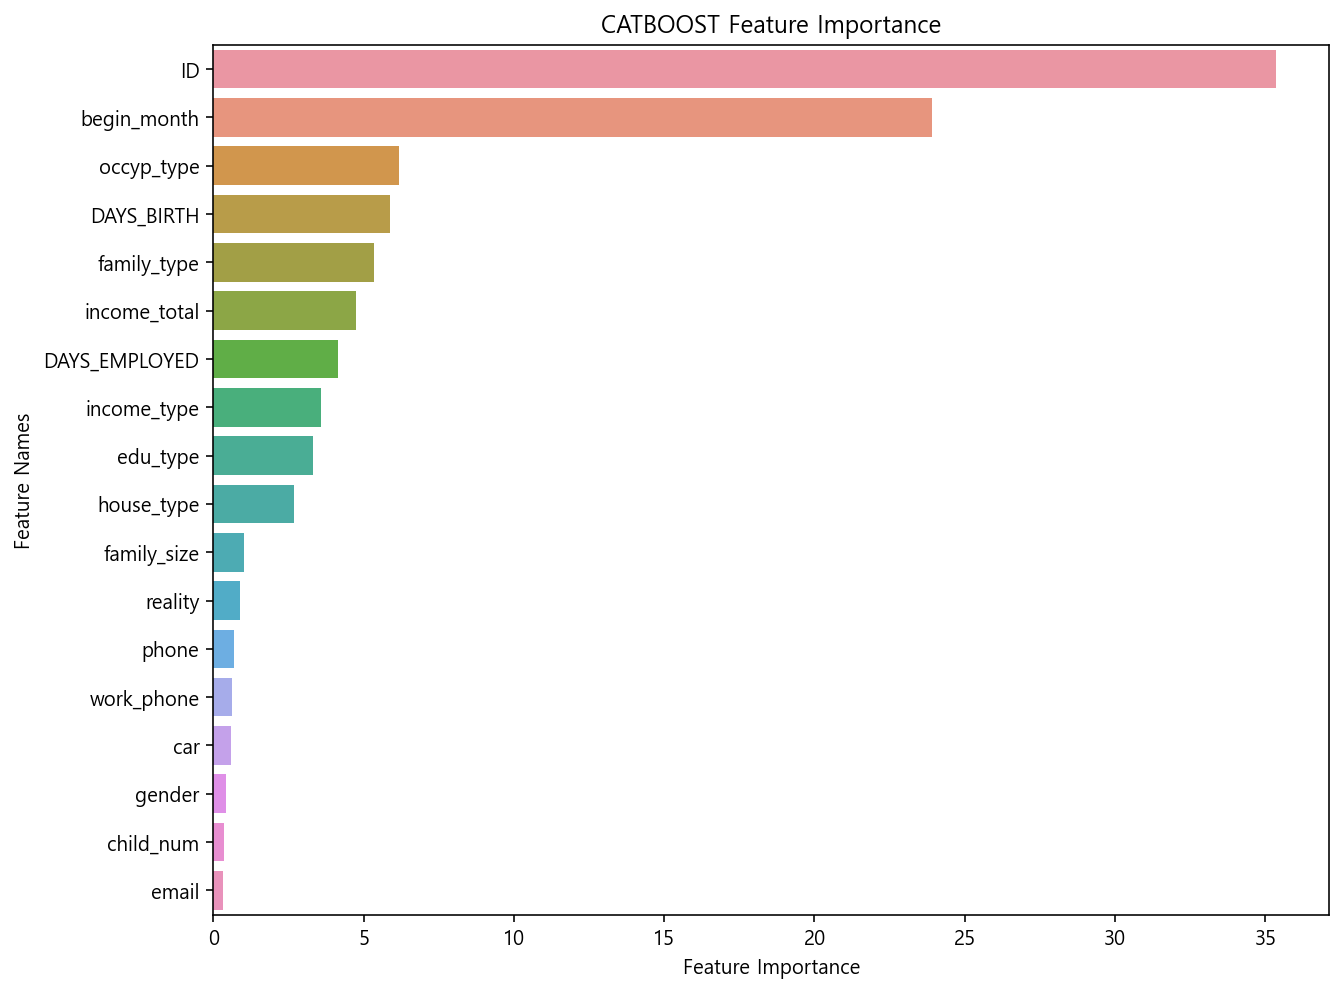

In [359]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [360]:
sub=pd.read_csv('../data/open/sample_submission.csv')

In [363]:
sub.iloc[:, 1:] = cat_pred_test
sub

,index,0,1,2
0,26457,0.150597,0.183457,0.665946
1,26458,0.329246,0.263493,0.407261
2,26459,0.054033,0.091117,0.854850
3,26460,0.068113,0.101762,0.830125
4,26461,0.081053,0.304716,0.614231
...,...,...,...,...
9995,36452,0.073302,0.325329,0.601370
9996,36453,0.404842,0.210935,0.384223
9997,36454,0.052584,0.163181,0.784236
9998,36455,0.170681,0.352300,0.477019


In [365]:
sub.to_csv('submissionzz_Final.csv', index=False)